# INFLATION OF MEXICO 
## FROM JANUARY 1970 TO MAY 2024

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visual plots
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler

# DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# LSTM Model
import torch
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device = torch.device('mps')

In [6]:
# Data collection
df = pd.read_csv('./data/INPC_Mexico.csv', na_values='N/E')

df.head(5)

,Fecha,SP30577,SP30579,SP30578,SP74660,SP74661,SP74662,SP74663,SP74664,SP74665
0,01/01/1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/02/1969,0.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/03/1969,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/04/1969,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/05/1969,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Database has MONTHLY data of the INPC (Inflation) of Mexico
### We are going to focus in 'SP30578' because this is the annual inflation rate

## Preprocess the DataFrame

In [7]:
df.rename(columns={'Fecha': 'Date', 'SP30578': 'INPC'})

,Date,SP30577,SP30579,INPC,SP74660,SP74661,SP74662,SP74663,SP74664,SP74665
0,01/01/1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/02/1969,0.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01/03/1969,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01/04/1969,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01/05/1969,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
660,01/01/2024,0.89,0.89,4.88,0.40,0.40,4.76,2.37,2.37,5.24
661,01/02/2024,0.09,0.99,4.40,0.49,0.90,4.64,-1.10,1.25,3.67
662,01/03/2024,0.29,1.28,4.42,0.44,1.34,4.55,-0.16,1.09,4.03
663,01/04/2024,0.20,1.48,4.65,0.21,1.55,4.37,0.18,1.27,5.54


In [8]:
# Change name and the type of the data
df.rename(columns={'Fecha': 'Date', 'SP30578': 'INPC'}, inplace=True)
df.dropna(subset='INPC', inplace=True)
df['INPC'] = df['INPC'].astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.tail(5)



,Date,SP30577,SP30579,INPC,SP74660,SP74661,SP74662,SP74663,SP74664,SP74665
660,2024-01-01,0.89,0.89,4.88,0.40,0.40,4.76,2.37,2.37,5.24
661,2024-02-01,0.09,0.99,4.40,0.49,0.90,4.64,-1.10,1.25,3.67
662,2024-03-01,0.29,1.28,4.42,0.44,1.34,4.55,-0.16,1.09,4.03
663,2024-04-01,0.20,1.48,4.65,0.21,1.55,4.37,0.18,1.27,5.54
664,2024-05-01,-0.19,1.29,4.69,0.17,1.73,4.21,-1.28,-0.02,6.19


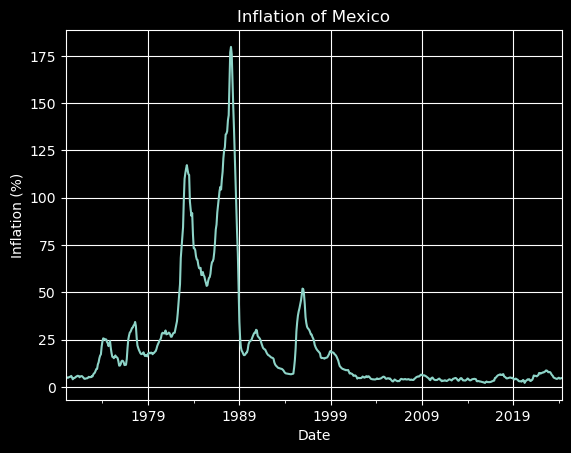

In [9]:
df.plot(x='Date', y='INPC', 
        ylabel='Inflation (%)', 
        legend='', 
        title='Inflation of Mexico',
        grid=True)
plt.show()

### In this case, because we are trying to predict the monthly inflation of the 2025 year.

In [10]:
# Data preprocessing

df.set_index('Date', inplace=True) # Set the index on TIME PERIOD
df = df["INPC"]

df

Date
1970-01-01    5.20
1970-02-01    4.81
1970-03-01    5.01
1970-04-01    4.87
1970-05-01    5.09
              ... 
2024-01-01    4.88
2024-02-01    4.40
2024-03-01    4.42
2024-04-01    4.65
2024-05-01    4.69
Name: INPC, Length: 653, dtype: float64

# LSTM MODEL with Pytorch

#### Split the data between train and testing

In [21]:
# Split into Training, Testing and Validation
def train_test_val_time_series_split(data, train_size:float, test_size:float, validation_size:float):
    # Steps
    train_size = int(len(data) * 0.7)
    test_size = int(len(data) * 0.2)
    validation_size = int(len(data) * 0.1) + 1 # matches the total data set
    
    print(f'Train size: {train_size}')
    print(f'Test size: {test_size}')
    print(f'Validation size: {validation_size}')
    print(f'Dataset size: {df.shape[0]}')
    
    # Split the data
    return np.array(data[:train_size]).reshape(-1, 1), np.array(data[train_size:train_size + test_size]).reshape(-1, 1), np.array(data[train_size + test_size:]).reshape(-1, 1)

data_train, data_test, data_val = train_test_val_time_series_split(df, train_size=0.7, test_size=0.2, validation_size=0.1)

# Scale the data
scaler = StandardScaler().fit(data_train) # Initialize the Scaler
scaled_data_train = scaler.transform(data_train)
scaled_data_test = scaler.transform(data_test)
scaled_data_validation = scaler.transform(data_val)

# Convert to tensors
data_train = torch.from_numpy(scaled_data_train).float()
data_test = torch.from_numpy(scaled_data_test).float()
data_val = torch.from_numpy(scaled_data_validation).float()

Train size: 457
Test size: 130
Validation size: 66
Dataset size: 653


### Build the DataLoader

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return x, y

In [23]:
seq_length = 12  # 12 months in a year

# Create datasets for each 
train_dataset = TimeSeriesDataset(data_train, seq_length)
test_dataset = TimeSeriesDataset(data_test, seq_length)
val_dataset = TimeSeriesDataset(data_val, seq_length)

batch_size = 10

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [24]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0)) # out: batch_size, seq_lenght, hidden_size
        out = self.fc(out[:, -1, :])

        return out

In [25]:
# Hyper-parameters
input_size = 1 # Number of features in the input
hidden_size = 128 # Number of features in the hidden state
num_layers = 2
output_size = 1 
learning_rate = 0.001
num_epochs = 20

In [32]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses_avg = [] # save the average train losses
test_losses_avg = [] # save the average test losses

best_test_loss = np.inf # Initialize the best train accuracy

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    correct = 0 # for accuracy metric
    total = 0 # for accuracy metric

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        train_losses.append(loss.item())  
    
    avg_train_loss = np.mean(train_losses)

    train_losses_avg.append(avg_train_loss) # save the average train losses

    print('*'*65)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Train: {avg_train_loss:.4f}')


# Testing loop
    model.eval()
    test_losses = []
    test_r2_scores = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            test_losses.append(loss.item())
            

    avg_test_loss = np.mean(test_losses)

    test_losses_avg.append(avg_test_loss) # save the average train losses
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Test: {avg_test_loss:.4f}')

    # Check if we have the best R² on the training dataset
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), './models/best_model.pth')
        print(f'Best model saved with Test Loss: {best_test_loss:.4f}')
    

*****************************************************************
Epoch [1/20], Loss Train: 0.9392
Epoch [1/20], Loss Test: 0.0308
Best model saved with Test Loss: 0.0308
*****************************************************************
Epoch [2/20], Loss Train: 0.3819
Epoch [2/20], Loss Test: 0.1309
*****************************************************************
Epoch [3/20], Loss Train: 0.2246
Epoch [3/20], Loss Test: 0.0360
*****************************************************************
Epoch [4/20], Loss Train: 0.1759
Epoch [4/20], Loss Test: 0.0139
Best model saved with Test Loss: 0.0139
*****************************************************************
Epoch [5/20], Loss Train: 0.1076
Epoch [5/20], Loss Test: 0.0041
Best model saved with Test Loss: 0.0041
*****************************************************************
Epoch [6/20], Loss Train: 0.0544
Epoch [6/20], Loss Test: 0.0041
*****************************************************************
Epoch [7/20], Loss Train: 0.

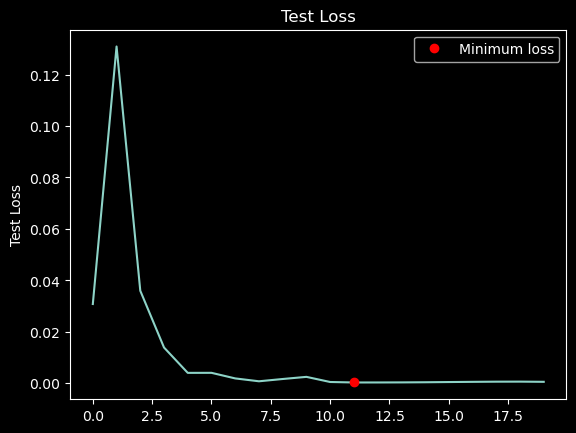

In [33]:
min_loss = np.array(test_losses_avg).min()
min_loss_index = test_losses_avg.index(min_loss)

plt.plot(test_losses_avg)
plt.plot(min_loss_index, min_loss,'ro', label='Minimum loss')
plt.title('Test Loss')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

## We are going to make a graph to see how well the model predictions are in the validation dataset

In [34]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('./models/best_model.pth'))
model.eval()


LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [40]:
predictions = []
actuals = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        #x = x.unsqueeze(-1)  # Add feature dimension
        outputs = model(x)
        predictions.append(outputs.squeeze().cpu().numpy())
        actuals.append(y.squeeze().cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the data
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_original = scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()


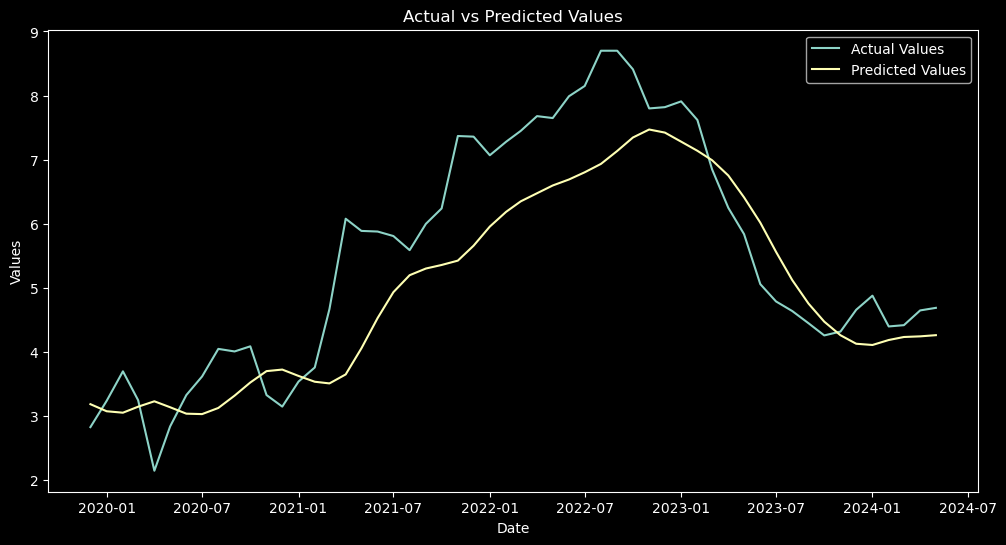

In [41]:
df_test = df.iloc[457 + 130 + seq_length:] # lag of 12
df_test = df_test.reset_index()
df_test['predictions'] = predictions_original

plt.figure(figsize=(12, 6))
plt.plot(df_test['Date'], df_test['INPC'], label='Actual Values')
plt.plot(df_test['Date'], df_test['predictions'], label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


# The LSTM model satisfactorily predicts Mexico's INPC

## Finally, we will try to predict the value of the INPC, within the next 6 months

In [52]:
# Your seq_length and initial data for prediction
seq_length = 12 
initial_data = df.values[-seq_length:].reshape(-1, 1)  # Last seq_length points to start predictions
initial_data_scaled = scaler.transform(initial_data)

# Function to predict next n_steps using the model
def predict_future(model, initial_data, n_steps, scaler):
    model.eval()
    predictions = []
    current_seq = initial_data.copy()

    for _ in range(n_steps):
        input_seq = torch.tensor(current_seq).unsqueeze(0).float().to(device)  # Shape: (1, seq_length, 1)
        with torch.no_grad():
            next_value = model(input_seq).item()
        predictions.append(next_value)
        
        # Update current_seq: Drop the first element and append the predicted value
        current_seq = np.append(current_seq[1:], next_value).reshape(-1, 1)

    # Inverse transform the predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions).flatten()

    return predictions_original

# Predict for the next 6 months
n_steps = 6
predictions_future = predict_future(model, initial_data_scaled, n_steps, scaler)


In [53]:
predicition_dates = ['2024-06-01', '2024-07-01', '2024-08-01',
                     '2024-09-01', '2024-10-01', '2024-11-01']
df_prediction = df[-seq_length:].reset_index().copy()
df_future = pd.DataFrame({'Date': predicition_dates, 'predictions': predictions_future})
df_future = pd.concat([df_prediction, df_future])


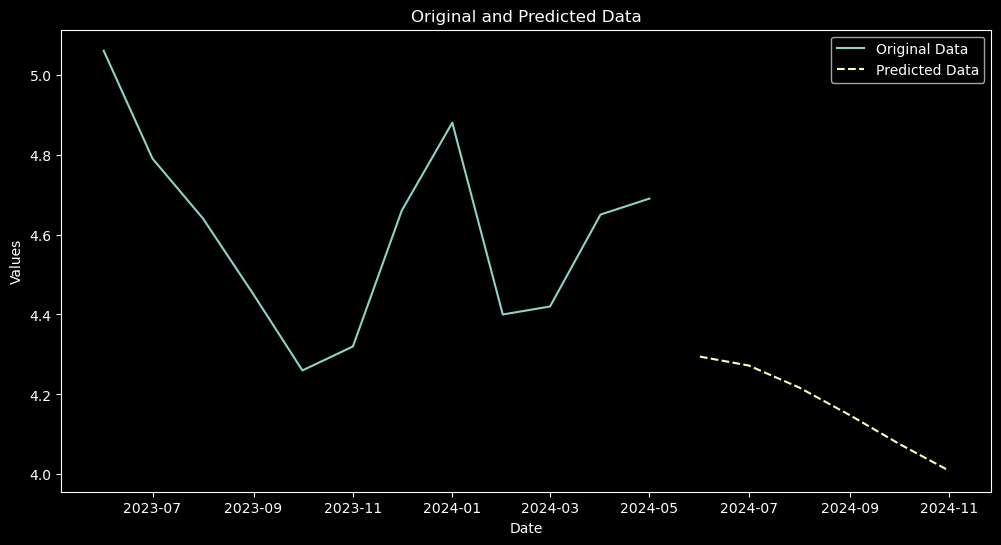

In [54]:
# Plot the original and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_future['Date'], df_future['INPC'], label='Original Data')
plt.plot(df_future['Date'], df_future['predictions'], label='Predicted Data', linestyle='--')
plt.title('Original and Predicted Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [55]:
df_future

,Date,INPC,predictions
0,2023-06-01 00:00:00,5.06,NaN
1,2023-07-01 00:00:00,4.79,NaN
2,2023-08-01 00:00:00,4.64,NaN
3,2023-09-01 00:00:00,4.45,NaN
4,2023-10-01 00:00:00,4.26,NaN
5,2023-11-01 00:00:00,4.32,NaN
6,2023-12-01 00:00:00,4.66,NaN
7,2024-01-01 00:00:00,4.88,NaN
8,2024-02-01 00:00:00,4.40,NaN
9,2024-03-01 00:00:00,4.42,NaN


# 